In [149]:
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from tqdm import tqdm
import audiomentations
from torch_audiomentations import Compose, PitchShift, TimeInversion, AddBackgroundNoise, AddColoredNoise, PolarityInversion
import torchaudio
import numpy as np
import sys
import matplotlib.pyplot as plt
import tensorboard
from torch.utils.tensorboard import SummaryWriter
from PIL import Image
from torchvision import transforms


sys.path.insert(0, '../src')
from segmentation import segment_cough

WRITER_PATH ="../logs/CNN_pretrain"

In [150]:
# Adapted from https://github.com/musikalkemist/pytorchforaudio
class CoughDataset(Dataset):

    def __init__(self,
                 annotations_df,
                 audio_dir,
                 target_sample_rate,
                 num_samples,
                 device,
                ):
        self.annotations = annotations_df
        self.audio_dir = audio_dir
        self.device = device
        self.target_sample_rate = target_sample_rate
        self.num_samples = num_samples
        self.label_dict = {'healthy':0, 'COVID-19':1}

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, index):
        audio_sample_path = self._get_audio_sample_path(index)
        label = self.label_dict[self._get_audio_sample_label(index)]
        signal, sr = torchaudio.load(audio_sample_path)
        
        signal = signal.to(self.device)
        signal = self._resample_if_necessary(signal, sr)
        signal = self._cut_if_necessary(signal)
        signal = self._right_pad_if_necessary(signal)
        
        return signal, label

    def _cut_if_necessary(self, signal):
        if signal.shape[1] > self.num_samples:
            signal = signal[:, :self.num_samples]
        return signal

    def _right_pad_if_necessary(self, signal):
        length_signal = signal.shape[1]
        if length_signal < self.num_samples:
            num_missing_samples = self.num_samples - length_signal
            last_dim_padding = (0, num_missing_samples)
            signal = torch.nn.functional.pad(signal, last_dim_padding)
        return signal

    def _resample_if_necessary(self, signal, sr):
        #print('resampled signal')
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal = resampler(signal)
        return signal

    def _get_audio_sample_path(self, index):
        path = os.path.join(self.audio_dir, self.annotations.iloc[index, 0])+".wav"
        return path


    def _get_audio_sample_label(self, index):
        return self.annotations.iloc[index, 9]




# Oversampled Dataset

In [151]:
AUDIO_DIR = "../valid_data/"
SAMPLE_RATE = 16000
NUM_SAMPLES = SAMPLE_RATE*10

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

train_df = pd.read_parquet(os.path.join(AUDIO_DIR, "train_balanced_3500.parquet.gzip"))
val_df = pd.read_parquet(os.path.join(AUDIO_DIR, "val_balanced_3500.parquet.gzip"))
test_df = pd.read_parquet(os.path.join(AUDIO_DIR, "test_balanced_3500.parquet.gzip"))


# print(f"There are {len(usd)} samples in the dataset.")
# signal, label = usd[0]

In [152]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet18', pretrained=True)

# Freeze model weights except for the last two layers
for param in model.parameters():
    param.requires_grad = False

# Replace the last two layers with new ones
model.fc = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 2),
    nn.LogSoftmax(dim=1)
)

model = model.to(device)


In [156]:
from sklearn.metrics import classification_report, confusion_matrix, f1_score


mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
).to(device)

def create_data_loader(train_data, batch_size):
    train_dataloader = DataLoader(train_data, batch_size=batch_size)
    print('train_dataloader finished: ', train_dataloader)
    return train_dataloader

def count_correct(logits, y_true):
    y_pred = torch.argmax(logits, axis = 1)
    return torch.sum(y_pred==y_true)

def train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device, do_augment=False):
    total_loss_train = 0.0
    correct_pred_train = 0.0
    total_pred_train = 0

    train_trues = []
    train_preds = []

    augmentations = Compose(
            transforms=[
                PitchShift(
                    mode = "per_example",
                    p=0.5,
                    sample_rate=SAMPLE_RATE,
                    output_type="tensor"
                    ),
                TimeInversion(
                    mode = "per_example",
                    p=0.5,
                    output_type="tensor"
                ),
                AddColoredNoise(
                    mode = "per_example",
                    p=0.5,
                    sample_rate=SAMPLE_RATE,
                    output_type="tensor"
                ),
                PolarityInversion(
                    mode="per_example",
                    p=0.5,
                    output_type="tensor"
                ), 

            ], output_type="tensor"
        )

    for x_batch, y_batch in tqdm(train_data_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        if do_augment:
            x_batch = augmentations(x_batch, SAMPLE_RATE)
        

        x_batch = x_batch.reshape(-1, x_batch.shape[-1])
        x_batch = mel_spectrogram(x_batch)
        x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])
        
        # calculate loss
        y_pred = model(x_batch)
        loss = loss_fn(y_pred, y_batch)

        # add to list for f1 score
        train_trues.append(y_batch.cpu())
        train_preds.append(y_pred.cpu())
        
        correct_pred_train += count_correct(y_pred, y_batch)
        total_pred_train += y_batch.shape[0]

        # backpropagate error and update weights
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        total_loss_train += loss.item()

        
        
    print(f"Training loss: {total_loss_train}, Training accuracy : {correct_pred_train/total_pred_train}")
    #print normalized loss
    print(f"Training loss normalized: {total_loss_train/len(train_data_loader)}")
    #print f1 score, precision, recall
    #print(confusion_matrix(torch.cat(train_trues).detach().cpu().numpy(), torch.cat(train_preds).detach().cpu().numpy()))
    #print(f1_score(torch.cat(train_trues).detach().cpu().numpy(), torch.argmax(torch.cat(train_preds), axis=1).detach().cpu().numpy(), average='macro'))
    # print(classification_report(torch.cat(train_trues).detach().cpu().numpy(), torch.argmax(torch.cat(train_preds), axis=1).detach().cpu().numpy()))
    
    total_loss_val = 0.0
    correct_pred_val = 0.0
    total_pred_val = 0

    val_trues = []
    val_preds = []

    for x_batch, y_batch in tqdm(val_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            x_batch = x_batch.reshape(-1, x_batch.shape[-1])
            x_batch = mel_spectrogram(x_batch)
            x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)
            total_loss_val += loss.item() 
            
            val_trues.append(y_batch.cpu())
            val_preds.append(y_pred.cpu())

        correct_pred_val += count_correct(y_pred, y_batch)
        total_pred_val += y_batch.shape[0]
        
    print(f"Validataion loss: {total_loss_val}, Validation accuracy : {correct_pred_val/total_pred_val}")
    #print normalized loss
    print(f"Validation loss normalized: {total_loss_val/len(val_data_loader)}")
    #print f1 score, confusion matrix and precision, recall using sklearn and true and predicted values
    # print(classification_report(torch.cat(val_trues).detach().cpu().numpy(), torch.argmax(torch.cat(val_preds), axis=1).detach().cpu().numpy()))
    return total_loss_train/len(train_data_loader), correct_pred_train/total_pred_train, total_loss_val/len(val_data_loader), correct_pred_val/total_pred_val


    
def train(model, train_data_loader, val_data_loader, loss_fn, optimiser, device, epochs, do_augment):
    writer = SummaryWriter(WRITER_PATH)
    for i in range(epochs):
        print(f"Epoch {i+1}")
        train_loss, train_acc, val_loss, val_acc = train_single_epoch(model, train_data_loader, val_data_loader, loss_fn, optimiser, device)
        writer.add_scalar("train/accuracy", train_acc, i)
        writer.add_scalar("train/loss", train_loss, i)
        writer.add_scalar("validation/accuracy", val_acc, i)
        writer.add_scalar("validation/loss", val_loss, i)
        
        path = os.path.join(MODEL_FOLDER, f"epoch_{i}.pth")
        torch.save(model.state_dict(), path)
        print(f"Saved at {path}")
        print("---------------------------")
    print("Finished training")
    print("---------------------------")

    
    
def evaluate(model, eval_data_loader, loss_fn, device):
    print("Evaluating model")
    total_loss = 0.0
    correct_pred = 0.0
    total_pred = 0
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            x_batch = x_batch.reshape(-1, x_batch.shape[-1])
            x_batch = mel_spectrogram(x_batch)
            x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])

            y_pred = model(x_batch)
            loss = loss_fn(y_pred, y_batch)

            correct_pred += count_correct(y_pred, y_batch)
            total_pred += y_batch.shape[0]

            total_loss += loss.item()
        
    print(f"Evaluation loss: {total_loss}, Evaluation accuracy : {correct_pred/total_pred}")
    print("---------------------------")

In [157]:
BATCH_SIZE =16
EPOCHS = 50
MODEL_FOLDER = '../models/'

train_data = CoughDataset(train_df,
                        AUDIO_DIR,
                        # mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device,
                        # augment = True
                        )
print('train data: ', train_data)

val_data = CoughDataset(val_df,
                        AUDIO_DIR,
                        # mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

test_data = CoughDataset(test_df,
                        AUDIO_DIR,
                        # mel_spectrogram,
                        SAMPLE_RATE,
                        NUM_SAMPLES,
                        device)

train_dataloader = create_data_loader(train_data, BATCH_SIZE)
val_dataloader = create_data_loader(val_data, BATCH_SIZE)
test_dataloader = create_data_loader(val_data, BATCH_SIZE)

# construct model and assign it to device
model = CNNNetwork().to(device)

# initialise loss funtion + optimiser
#loss_fn = nn.CrossEntropyLoss(weight=train_data.label_weights)
loss_fn = nn.CrossEntropyLoss()
optimiser = torch.optim.Adam(model.parameters())

train data:  <__main__.CoughDataset object at 0x148593f40>
train_dataloader finished:  <torch.utils.data.dataloader.DataLoader object at 0x148593700>
train_dataloader finished:  <torch.utils.data.dataloader.DataLoader object at 0x288db9a50>
train_dataloader finished:  <torch.utils.data.dataloader.DataLoader object at 0x1485935b0>


In [158]:
train(model, train_dataloader, val_dataloader, loss_fn, optimiser, device, EPOCHS, do_augment=True)

Epoch 1


100%|██████████| 355/355 [01:03<00:00,  5.57it/s]


Training loss: 290.84443521499634, Training accuracy : 0.49347442388534546
Training loss normalized: 0.8192800991971728


100%|██████████| 40/40 [00:06<00:00,  6.66it/s]


Validataion loss: 32.52878111600876, Validation accuracy : 0.5
Validation loss normalized: 0.813219527900219
Saved at ../models/epoch_0.pth
---------------------------
Epoch 2


100%|██████████| 355/355 [01:04<00:00,  5.52it/s]


Training loss: 288.6048409342766, Training accuracy : 0.5008818507194519
Training loss normalized: 0.8129713829134552


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Validataion loss: 32.467961966991425, Validation accuracy : 0.5015873312950134
Validation loss normalized: 0.8116990491747856
Saved at ../models/epoch_1.pth
---------------------------
Epoch 3


100%|██████████| 355/355 [01:04<00:00,  5.54it/s]


Training loss: 289.9129908978939, Training accuracy : 0.4952380955219269
Training loss normalized: 0.8166563123884335


100%|██████████| 40/40 [00:06<00:00,  6.26it/s]


Validataion loss: 34.42601811885834, Validation accuracy : 0.4571428596973419
Validation loss normalized: 0.8606504529714585
Saved at ../models/epoch_2.pth
---------------------------
Epoch 4


100%|██████████| 355/355 [01:02<00:00,  5.64it/s]


Training loss: 291.33130341768265, Training accuracy : 0.49153438210487366
Training loss normalized: 0.8206515589230498


100%|██████████| 40/40 [00:05<00:00,  6.92it/s]


Validataion loss: 32.96689370274544, Validation accuracy : 0.4888888895511627
Validation loss normalized: 0.8241723425686359
Saved at ../models/epoch_3.pth
---------------------------
Epoch 5


100%|██████████| 355/355 [01:03<00:00,  5.61it/s]


Training loss: 288.3183085024357, Training accuracy : 0.5008818507194519
Training loss normalized: 0.8121642493026358


100%|██████████| 40/40 [00:06<00:00,  6.51it/s]


Validataion loss: 32.759654611349106, Validation accuracy : 0.4968253970146179
Validation loss normalized: 0.8189913652837276
Saved at ../models/epoch_4.pth
---------------------------
Epoch 6


100%|██████████| 355/355 [01:01<00:00,  5.78it/s]


Training loss: 288.4722254574299, Training accuracy : 0.5001763701438904
Training loss normalized: 0.8125978181899434


100%|██████████| 40/40 [00:05<00:00,  6.80it/s]


Validataion loss: 32.69713595509529, Validation accuracy : 0.49841269850730896
Validation loss normalized: 0.8174283988773823
Saved at ../models/epoch_5.pth
---------------------------
Epoch 7


100%|██████████| 355/355 [01:04<00:00,  5.52it/s]


Training loss: 288.51853880286217, Training accuracy : 0.5003527402877808
Training loss normalized: 0.8127282783179216


100%|██████████| 40/40 [00:07<00:00,  5.45it/s]


Validataion loss: 33.017561078071594, Validation accuracy : 0.49047619104385376
Validation loss normalized: 0.8254390269517898
Saved at ../models/epoch_6.pth
---------------------------
Epoch 8


100%|██████████| 355/355 [01:08<00:00,  5.18it/s]


Training loss: 289.0320424437523, Training accuracy : 0.4989418089389801
Training loss normalized: 0.8141747674471895


100%|██████████| 40/40 [00:06<00:00,  5.92it/s]


Validataion loss: 33.23585766553879, Validation accuracy : 0.4841269850730896
Validation loss normalized: 0.8308964416384697
Saved at ../models/epoch_7.pth
---------------------------
Epoch 9


100%|██████████| 355/355 [01:09<00:00,  5.10it/s]


Training loss: 286.38390573859215, Training accuracy : 0.5061728358268738
Training loss normalized: 0.8067152274326539


100%|██████████| 40/40 [00:06<00:00,  6.27it/s]


Validataion loss: 32.734548449516296, Validation accuracy : 0.4952380955219269
Validation loss normalized: 0.8183637112379074
Saved at ../models/epoch_8.pth
---------------------------
Epoch 10


100%|██████████| 355/355 [01:05<00:00,  5.44it/s]


Training loss: 284.659321308136, Training accuracy : 0.5111111402511597
Training loss normalized: 0.8018572431215099


100%|██████████| 40/40 [00:06<00:00,  6.13it/s]


Validataion loss: 32.90380537509918, Validation accuracy : 0.49047619104385376
Validation loss normalized: 0.8225951343774796
Saved at ../models/epoch_9.pth
---------------------------
Epoch 11


100%|██████████| 355/355 [01:01<00:00,  5.73it/s]


Training loss: 286.2584782242775, Training accuracy : 0.5070546865463257
Training loss normalized: 0.8063619104909225


100%|██████████| 40/40 [00:06<00:00,  6.38it/s]


Validataion loss: 32.25676840543747, Validation accuracy : 0.5031746029853821
Validation loss normalized: 0.8064192101359368
Saved at ../models/epoch_10.pth
---------------------------
Epoch 12


100%|██████████| 355/355 [01:09<00:00,  5.12it/s]


Training loss: 280.94178533554077, Training accuracy : 0.5223985910415649
Training loss normalized: 0.7913853108043402


100%|██████████| 40/40 [00:06<00:00,  5.98it/s]


Validataion loss: 31.337445735931396, Validation accuracy : 0.5285714268684387
Validation loss normalized: 0.7834361433982849
Saved at ../models/epoch_11.pth
---------------------------
Epoch 13


100%|██████████| 355/355 [01:05<00:00,  5.46it/s]


Training loss: 277.87539038062096, Training accuracy : 0.5301587581634521
Training loss normalized: 0.7827475785369604


100%|██████████| 40/40 [00:05<00:00,  6.70it/s]


Validataion loss: 31.325035870075226, Validation accuracy : 0.5269841551780701
Validation loss normalized: 0.7831258967518806
Saved at ../models/epoch_12.pth
---------------------------
Epoch 14


100%|██████████| 355/355 [01:05<00:00,  5.41it/s]


Training loss: 280.44884756207466, Training accuracy : 0.5220458507537842
Training loss normalized: 0.789996753695985


100%|██████████| 40/40 [00:06<00:00,  6.23it/s]


Validataion loss: 31.726591885089874, Validation accuracy : 0.5158730149269104
Validation loss normalized: 0.7931647971272469
Saved at ../models/epoch_13.pth
---------------------------
Epoch 15


100%|██████████| 355/355 [01:04<00:00,  5.53it/s]


Training loss: 280.67992237210274, Training accuracy : 0.5209876298904419
Training loss normalized: 0.7906476686538105


100%|██████████| 40/40 [00:06<00:00,  6.53it/s]


Validataion loss: 30.96299511194229, Validation accuracy : 0.5396825671195984
Validation loss normalized: 0.7740748777985573
Saved at ../models/epoch_14.pth
---------------------------
Epoch 16


100%|██████████| 355/355 [01:01<00:00,  5.75it/s]


Training loss: 275.77992582321167, Training accuracy : 0.5359788537025452
Training loss normalized: 0.7768448614738357


100%|██████████| 40/40 [00:05<00:00,  6.83it/s]


Validataion loss: 30.515715777873993, Validation accuracy : 0.5492063760757446
Validation loss normalized: 0.7628928944468498
Saved at ../models/epoch_15.pth
---------------------------
Epoch 17


100%|██████████| 355/355 [01:04<00:00,  5.47it/s]


Training loss: 272.09609442949295, Training accuracy : 0.5465608239173889
Training loss normalized: 0.7664678716323745


100%|██████████| 40/40 [00:06<00:00,  6.23it/s]


Validataion loss: 30.668394327163696, Validation accuracy : 0.5460317730903625
Validation loss normalized: 0.7667098581790924
Saved at ../models/epoch_16.pth
---------------------------
Epoch 18


100%|██████████| 355/355 [01:05<00:00,  5.40it/s]


Training loss: 272.72587352991104, Training accuracy : 0.5447971820831299
Training loss normalized: 0.768241897267355


100%|██████████| 40/40 [00:06<00:00,  6.58it/s]


Validataion loss: 30.23329484462738, Validation accuracy : 0.5571428537368774
Validation loss normalized: 0.7558323711156845
Saved at ../models/epoch_17.pth
---------------------------
Epoch 19


100%|██████████| 355/355 [01:02<00:00,  5.69it/s]


Training loss: 279.0305376648903, Training accuracy : 0.5271604657173157
Training loss normalized: 0.7860015145489867


100%|██████████| 40/40 [00:05<00:00,  6.73it/s]


Validataion loss: 31.00445768237114, Validation accuracy : 0.5365079641342163
Validation loss normalized: 0.7751114420592785
Saved at ../models/epoch_18.pth
---------------------------
Epoch 20


100%|██████████| 355/355 [01:04<00:00,  5.48it/s]


Training loss: 278.97352823615074, Training accuracy : 0.527336835861206
Training loss normalized: 0.7858409246088753


100%|██████████| 40/40 [00:05<00:00,  6.91it/s]


Validataion loss: 31.161494314670563, Validation accuracy : 0.5317460298538208
Validation loss normalized: 0.7790373578667641
Saved at ../models/epoch_19.pth
---------------------------
Epoch 21


100%|██████████| 355/355 [01:00<00:00,  5.84it/s]


Training loss: 278.7743866741657, Training accuracy : 0.5276895761489868
Training loss normalized: 0.7852799624624387


100%|██████████| 40/40 [00:05<00:00,  6.94it/s]


Validataion loss: 29.486530989408493, Validation accuracy : 0.5682539939880371
Validation loss normalized: 0.7371632747352124
Saved at ../models/epoch_20.pth
---------------------------
Epoch 22


100%|██████████| 355/355 [01:04<00:00,  5.46it/s]


Training loss: 276.16291362047195, Training accuracy : 0.5347442626953125
Training loss normalized: 0.7779237003393576


100%|██████████| 40/40 [00:06<00:00,  6.61it/s]


Validataion loss: 30.019538074731827, Validation accuracy : 0.5539682507514954
Validation loss normalized: 0.7504884518682957
Saved at ../models/epoch_21.pth
---------------------------
Epoch 23


100%|██████████| 355/355 [01:03<00:00,  5.57it/s]


Training loss: 274.3255341053009, Training accuracy : 0.5402116179466248
Training loss normalized: 0.7727479833952138


100%|██████████| 40/40 [00:06<00:00,  6.56it/s]


Validataion loss: 29.261101871728897, Validation accuracy : 0.5761904716491699
Validation loss normalized: 0.7315275467932224
Saved at ../models/epoch_22.pth
---------------------------
Epoch 24


100%|██████████| 355/355 [01:03<00:00,  5.60it/s]


Training loss: 273.5035001039505, Training accuracy : 0.5425044298171997
Training loss normalized: 0.7704323946590155


100%|██████████| 40/40 [00:06<00:00,  6.65it/s]


Validataion loss: 29.808273375034332, Validation accuracy : 0.561904788017273
Validation loss normalized: 0.7452068343758583
Saved at ../models/epoch_23.pth
---------------------------
Epoch 25


100%|██████████| 355/355 [01:02<00:00,  5.65it/s]


Training loss: 274.3784548640251, Training accuracy : 0.539858877658844
Training loss normalized: 0.7728970559550004


100%|██████████| 40/40 [00:06<00:00,  6.15it/s]


Validataion loss: 30.224865078926086, Validation accuracy : 0.5555555820465088
Validation loss normalized: 0.7556216269731522
Saved at ../models/epoch_24.pth
---------------------------
Epoch 26


100%|██████████| 355/355 [01:02<00:00,  5.64it/s]


Training loss: 273.8739648759365, Training accuracy : 0.5414462089538574
Training loss normalized: 0.7714759573970043


100%|██████████| 40/40 [00:05<00:00,  6.82it/s]


Validataion loss: 29.983889877796173, Validation accuracy : 0.561904788017273
Validation loss normalized: 0.7495972469449044
Saved at ../models/epoch_25.pth
---------------------------
Epoch 27


100%|██████████| 355/355 [01:03<00:00,  5.58it/s]


Training loss: 278.0760121643543, Training accuracy : 0.5298060178756714
Training loss normalized: 0.7833127103221249


100%|██████████| 40/40 [00:05<00:00,  6.89it/s]


Validataion loss: 30.27447673678398, Validation accuracy : 0.5507936477661133
Validation loss normalized: 0.7568619184195995
Saved at ../models/epoch_26.pth
---------------------------
Epoch 28


100%|██████████| 355/355 [01:03<00:00,  5.59it/s]


Training loss: 277.49699091911316, Training accuracy : 0.5317460298538208
Training loss normalized: 0.7816816645608822


100%|██████████| 40/40 [00:05<00:00,  6.77it/s]


Validataion loss: 30.453407645225525, Validation accuracy : 0.5492063760757446
Validation loss normalized: 0.7613351911306381
Saved at ../models/epoch_27.pth
---------------------------
Epoch 29


100%|██████████| 355/355 [01:03<00:00,  5.63it/s]


Training loss: 276.30246192216873, Training accuracy : 0.5347442626953125
Training loss normalized: 0.7783167941469542


100%|██████████| 40/40 [00:05<00:00,  6.86it/s]


Validataion loss: 29.892119228839874, Validation accuracy : 0.5666666626930237
Validation loss normalized: 0.7473029807209969
Saved at ../models/epoch_28.pth
---------------------------
Epoch 30


100%|██████████| 355/355 [01:01<00:00,  5.80it/s]


Training loss: 274.9748262166977, Training accuracy : 0.5386243462562561
Training loss normalized: 0.7745769752583034


100%|██████████| 40/40 [00:05<00:00,  6.86it/s]


Validataion loss: 29.776439487934113, Validation accuracy : 0.5730158686637878
Validation loss normalized: 0.7444109871983529
Saved at ../models/epoch_29.pth
---------------------------
Epoch 31


100%|██████████| 355/355 [01:00<00:00,  5.82it/s]


Training loss: 271.933984875679, Training accuracy : 0.5469135642051697
Training loss normalized: 0.7660112250019128


100%|██████████| 40/40 [00:05<00:00,  6.77it/s]


Validataion loss: 31.39712816476822, Validation accuracy : 0.5317460298538208
Validation loss normalized: 0.7849282041192055
Saved at ../models/epoch_30.pth
---------------------------
Epoch 32


100%|██████████| 355/355 [01:02<00:00,  5.64it/s]


Training loss: 274.61273047327995, Training accuracy : 0.5393298268318176
Training loss normalized: 0.7735569872486759


100%|██████████| 40/40 [00:06<00:00,  6.63it/s]


Validataion loss: 29.5291029214859, Validation accuracy : 0.5730158686637878
Validation loss normalized: 0.7382275730371475
Saved at ../models/epoch_31.pth
---------------------------
Epoch 33


100%|██████████| 355/355 [01:01<00:00,  5.74it/s]


Training loss: 270.20928049087524, Training accuracy : 0.5518518686294556
Training loss normalized: 0.7611529027911978


100%|██████████| 40/40 [00:05<00:00,  6.75it/s]


Validataion loss: 29.112654089927673, Validation accuracy : 0.5841270089149475
Validation loss normalized: 0.7278163522481919
Saved at ../models/epoch_32.pth
---------------------------
Epoch 34


100%|██████████| 355/355 [01:03<00:00,  5.60it/s]


Training loss: 269.0038773417473, Training accuracy : 0.5550264716148376
Training loss normalized: 0.7577574009626684


100%|██████████| 40/40 [00:06<00:00,  6.50it/s]


Validataion loss: 29.15621840953827, Validation accuracy : 0.5857142806053162
Validation loss normalized: 0.7289054602384567
Saved at ../models/epoch_33.pth
---------------------------
Epoch 35


100%|██████████| 355/355 [01:03<00:00,  5.57it/s]


Training loss: 270.88198482990265, Training accuracy : 0.5500881671905518
Training loss normalized: 0.7630478445912751


100%|██████████| 40/40 [00:06<00:00,  6.51it/s]


Validataion loss: 29.700197130441666, Validation accuracy : 0.5666666626930237
Validation loss normalized: 0.7425049282610416
Saved at ../models/epoch_34.pth
---------------------------
Epoch 36


100%|██████████| 355/355 [01:04<00:00,  5.51it/s]


Training loss: 272.13740184903145, Training accuracy : 0.5463844537734985
Training loss normalized: 0.766584230560652


100%|██████████| 40/40 [00:06<00:00,  6.45it/s]


Validataion loss: 29.29531556367874, Validation accuracy : 0.579365074634552
Validation loss normalized: 0.7323828890919686
Saved at ../models/epoch_35.pth
---------------------------
Epoch 37


100%|██████████| 355/355 [01:04<00:00,  5.51it/s]


Training loss: 269.87732580304146, Training accuracy : 0.5529100298881531
Training loss normalized: 0.7602178191634971


100%|██████████| 40/40 [00:05<00:00,  6.69it/s]


Validataion loss: 30.23066234588623, Validation accuracy : 0.5603174567222595
Validation loss normalized: 0.7557665586471558
Saved at ../models/epoch_36.pth
---------------------------
Epoch 38


100%|██████████| 355/355 [01:04<00:00,  5.51it/s]


Training loss: 275.1046911776066, Training accuracy : 0.538095235824585
Training loss normalized: 0.774942792049596


100%|██████████| 40/40 [00:06<00:00,  6.35it/s]


Validataion loss: 30.343145787715912, Validation accuracy : 0.5555555820465088
Validation loss normalized: 0.7585786446928978
Saved at ../models/epoch_37.pth
---------------------------
Epoch 39


100%|██████████| 355/355 [01:04<00:00,  5.47it/s]


Training loss: 273.91411954164505, Training accuracy : 0.5410934686660767
Training loss normalized: 0.7715890691313945


100%|██████████| 40/40 [00:06<00:00,  6.49it/s]


Validataion loss: 30.589827835559845, Validation accuracy : 0.5492063760757446
Validation loss normalized: 0.7647456958889961
Saved at ../models/epoch_38.pth
---------------------------
Epoch 40


100%|██████████| 355/355 [01:05<00:00,  5.42it/s]


Training loss: 275.5587278008461, Training accuracy : 0.5366842746734619
Training loss normalized: 0.7762217684530877


100%|██████████| 40/40 [00:06<00:00,  6.24it/s]


Validataion loss: 30.288450479507446, Validation accuracy : 0.5571428537368774
Validation loss normalized: 0.7572112619876862
Saved at ../models/epoch_39.pth
---------------------------
Epoch 41


100%|██████████| 355/355 [01:03<00:00,  5.57it/s]


Training loss: 276.27851605415344, Training accuracy : 0.5350970029830933
Training loss normalized: 0.7782493409976153


100%|██████████| 40/40 [00:05<00:00,  6.71it/s]


Validataion loss: 30.02212744951248, Validation accuracy : 0.5634920597076416
Validation loss normalized: 0.7505531862378121
Saved at ../models/epoch_40.pth
---------------------------
Epoch 42


100%|██████████| 355/355 [01:02<00:00,  5.72it/s]


Training loss: 274.00558120012283, Training accuracy : 0.5416225790977478
Training loss normalized: 0.7718467076059798


100%|██████████| 40/40 [00:06<00:00,  5.83it/s]


Validataion loss: 30.466431081295013, Validation accuracy : 0.5523809790611267
Validation loss normalized: 0.7616607770323753
Saved at ../models/epoch_41.pth
---------------------------
Epoch 43


100%|██████████| 355/355 [01:04<00:00,  5.53it/s]


Training loss: 277.0137207508087, Training accuracy : 0.5326278805732727
Training loss normalized: 0.7803203401431231


100%|██████████| 40/40 [00:06<00:00,  6.43it/s]


Validataion loss: 30.05698788166046, Validation accuracy : 0.561904788017273
Validation loss normalized: 0.7514246970415115
Saved at ../models/epoch_42.pth
---------------------------
Epoch 44


100%|██████████| 355/355 [01:03<00:00,  5.58it/s]


Training loss: 275.9883315563202, Training accuracy : 0.5358024835586548
Training loss normalized: 0.7774319198769583


100%|██████████| 40/40 [00:06<00:00,  6.59it/s]


Validataion loss: 30.789343893527985, Validation accuracy : 0.541269838809967
Validation loss normalized: 0.7697335973381996
Saved at ../models/epoch_43.pth
---------------------------
Epoch 45


100%|██████████| 355/355 [01:04<00:00,  5.48it/s]


Training loss: 274.4797983765602, Training accuracy : 0.539858877658844
Training loss normalized: 0.7731825306381978


100%|██████████| 40/40 [00:06<00:00,  6.33it/s]


Validataion loss: 29.77739429473877, Validation accuracy : 0.5666666626930237
Validation loss normalized: 0.7444348573684693
Saved at ../models/epoch_44.pth
---------------------------
Epoch 46


100%|██████████| 355/355 [01:07<00:00,  5.24it/s]


Training loss: 272.57768577337265, Training accuracy : 0.5455026626586914
Training loss normalized: 0.7678244669672469


100%|██████████| 40/40 [00:07<00:00,  5.71it/s]


Validataion loss: 30.741661369800568, Validation accuracy : 0.5428571701049805
Validation loss normalized: 0.7685415342450141
Saved at ../models/epoch_45.pth
---------------------------
Epoch 47


100%|██████████| 355/355 [01:06<00:00,  5.30it/s]


Training loss: 275.62524327635765, Training accuracy : 0.5365079641342163
Training loss normalized: 0.7764091359897398


100%|██████████| 40/40 [00:06<00:00,  6.61it/s]


Validataion loss: 30.792685329914093, Validation accuracy : 0.5444444417953491
Validation loss normalized: 0.7698171332478523
Saved at ../models/epoch_46.pth
---------------------------
Epoch 48


100%|██████████| 355/355 [01:01<00:00,  5.77it/s]


Training loss: 275.5839924812317, Training accuracy : 0.5365079641342163
Training loss normalized: 0.7762929365668498


100%|██████████| 40/40 [00:05<00:00,  6.71it/s]


Validataion loss: 29.713249802589417, Validation accuracy : 0.5682539939880371
Validation loss normalized: 0.7428312450647354
Saved at ../models/epoch_47.pth
---------------------------
Epoch 49


100%|██████████| 355/355 [01:01<00:00,  5.73it/s]


Training loss: 277.2092040479183, Training accuracy : 0.5322751402854919
Training loss normalized: 0.7808709973180797


100%|██████████| 40/40 [00:05<00:00,  6.71it/s]


Validataion loss: 30.233523160219193, Validation accuracy : 0.5523809790611267
Validation loss normalized: 0.7558380790054798
Saved at ../models/epoch_48.pth
---------------------------
Epoch 50


100%|██████████| 355/355 [01:01<00:00,  5.75it/s]


Training loss: 275.13389214873314, Training accuracy : 0.5382716059684753
Training loss normalized: 0.7750250483062905


100%|██████████| 40/40 [00:05<00:00,  6.73it/s]

Validataion loss: 30.4926900267601, Validation accuracy : 0.5492063760757446
Validation loss normalized: 0.7623172506690026
Saved at ../models/epoch_49.pth
---------------------------
Finished training
---------------------------


In [163]:
#set model to be the epoch 34 model in the models folder
model.load_state_dict(torch.load('../models/epoch_32.pth'))
# evaluate model with test data using the loaded model




evaluate(model, test_dataloader, loss_fn, device)

Evaluating model


100%|██████████| 40/40 [00:05<00:00,  6.83it/s]

Evaluation loss: 28.844421803951263, Evaluation accuracy : 0.5936508178710938
---------------------------


In [164]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import numpy as np

In [165]:
from sklearn.metrics import plot_confusion_matrix

mel_spectrogram = torchaudio.transforms.MelSpectrogram(
    sample_rate=SAMPLE_RATE,
    n_fft=1024,
    hop_length=512,
    n_mels=128
)

def evaluate_confusion(model, eval_data_loader, device):
    trues = []
    preds =[]
    for x_batch, y_batch in tqdm(eval_data_loader):
        with torch.no_grad():
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            x_batch = x_batch.reshape(-1, x_batch.shape[-1])
            #print('x_batch after (batch*channel, time): ', x_batch.shape)
            x_batch = mel_spectrogram(x_batch)
            #print('x_batch after mel: ', x_batch.shape)
            x_batch = x_batch.reshape(x_batch.shape[0], 1, x_batch.shape[-2], x_batch.shape[-1])
            
            # calculate loss
            y_pred = model(x_batch)


            trues += torch.clamp(y_batch, max=1)


            preds += torch.clamp(torch.argmax(y_pred, axis = 1), max=1)
            
            
    return np.array(trues), np.array(preds)
        




In [166]:
trues, preds = evaluate_confusion(model, test_dataloader, device)

100%|██████████| 40/40 [00:05<00:00,  6.74it/s]


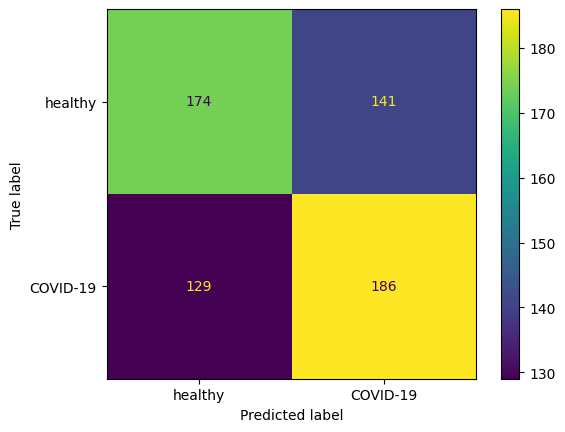

In [167]:
cfm = confusion_matrix(trues, preds)
#ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'symptomatic', 'COVID-19']).plot()
ConfusionMatrixDisplay(cfm, display_labels=['healthy', 'COVID-19']).plot()

              precision    recall  f1-score   support

           0       0.57      0.55      0.56       315
           1       0.57      0.59      0.58       315

    accuracy                           0.57       630
   macro avg       0.57      0.57      0.57       630
weighted avg       0.57      0.57      0.57       630

f1:  0.5712730242264767
roc:  0.5714285714285715


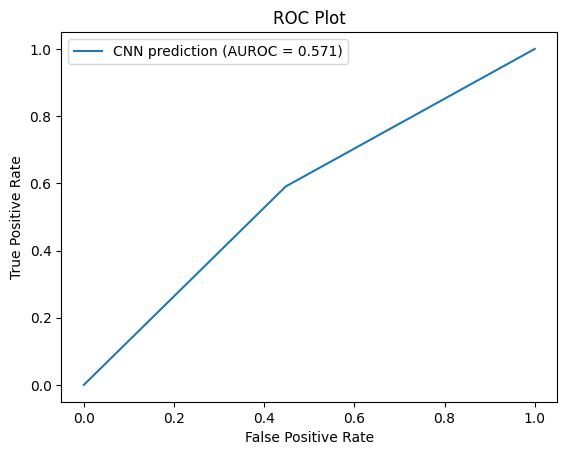

In [168]:
# print classification report
from sklearn.metrics import classification_report
print(classification_report(trues, preds))

# calculate f1 score
from sklearn.metrics import f1_score
print('f1: ', f1_score(trues, preds, average='macro'))

#calculate and graph ROC AUC
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve
r_auc = roc_auc_score(trues, preds)
print('roc: ', r_auc)

fpr, tpr, thresholds = roc_curve(trues, preds)
plt.plot(fpr, tpr, label='CNN prediction (AUROC = %0.3f)' % r_auc)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Show legend
plt.legend() # 
# Show plot
plt.show()

In [73]:
preds.dtype

dtype('int64')